Name(s): John Michael Tran

# HW7: Association Analysis (continued)

In the previous homework, you implemented the Apriori algorithm to find the frequent itemsets that meet a min_sup threshold in a dataset. Now, you will implement the Rule Gen algorithm to extract the strong rules, that meet a min_conf threshold, from those frequent itemsets. 

For the first part of this assignment, you will read in the frequent itemsets that have been found in a dataset. The file `large_freq_itemsets.txt` contains the frequent itemsets and support data found in a large retail dataset.

You are also provided with a `small_freq_itemsets.txt` file which contains the frequent itemsets and support data found in a small retail dataset.

The `load_dataset` function returns a dictionary containing a mapping of frequent itemsets to their support counts.

In [177]:
# Standard imports (you can add additional headers if you wish)
import numpy as np

In [178]:
# Reading the frequent itemset files
def load_dataset(file_name):
    sup_data = {}
    with open(file_name, 'r') as f:
        f.readline() # skip column headers
        for line in f:
            split_line = line.split('\t')
            sup_data[split_line[1].strip()] = split_line[0]

    return sup_data

In [179]:
# Read in the small_freq_itemsets file
small_sup_data = load_dataset('small_freq_itemsets.txt')
print("\nSmall dataset frequent itemsets:\n", small_sup_data)


Small dataset frequent itemsets:
 {'[1]': '0.67', '[2]': '0.78', '[3]': '0.67', '[4]': '0.22', '[5]': '0.22', '[1, 2]': '0.44', '[1, 3]': '0.44', '[1, 5]': '0.22', '[2, 3]': '0.44', '[2, 4]': '0.22', '[2, 5]': '0.22', '[1, 2, 3]': '0.22', '[1, 2, 5]': '0.22'}


## Part 1 - Closed Freq Itemsets & Rule Gen

Q1. First, let's find the closed frequent itemsets from the frequent itemsets. Given a dictionary of all of the frequent itemsets and their supports, find the closed frequent item sets along with their support. Display the results in the same format as specified in Homework 6 (a tab-separated table), as shown below.

The closed frequent itemsets for the `small_retail` dataset are as follows:

~~~~
Sup     Freq Itemset
0.67	[1]
0.78	[2]
0.67	[3]
0.44	[1, 2]
0.44	[1, 3]
0.44	[2, 3]
0.22	[2, 4]
0.22	[1, 2, 3]
0.22	[1, 2, 5]
~~~~

Display the closed frequent itemsests for the `large_retail` dataset.

In [180]:
def closed_freq_itemsets(sup_data):
    keys = list(sup_data.keys())
    valid_keys = list(sup_data.keys())
    num_keys = len(keys)
    for i in range(num_keys - 1) :
        curr_set = keys[i]
        for j in range(i+1, num_keys) :
            next_set = keys[j]
            if set(next_set).issuperset(curr_set) :
                if sup_data[curr_set] == sup_data[next_set] :
                    valid_keys.remove(curr_set)   
                    break
    
    print("Sup\tFreq Itemset")
    for valid in valid_keys :
        print(str(sup_data[valid]) + "\t" + str(valid))
large_sup_data = load_dataset('large_freq_itemsets.txt')
closed_freq_itemsets(large_sup_data)

Sup	Freq Itemset
0.1	[31]
0.11	[36]
0.26	[38]
0.53	[39]
0.22	[41]
0.47	[48]
0.11	[60]
0.11	[65]
0.11	[89]
0.14	[32, 39]
0.15	[38, 39]
0.13	[38, 48]
0.33	[39, 48]
0.18	[41, 48]
0.14	[39, 41, 48]


Q2. Now, generate the strong rules from the frequent itemsets. Given a dictionary of frequent itemsets and their supports, generate all the rules having confidence above some provided `min_conf` threshold. Display the rules in the form of a table.

Sample table format (tab separated table):

~~~
Sup     Conf    Rule
0.44	0.67	[1] -> [2]
0.22	1.0	 [5] -> [1, 2]
0.22	1.0	 [2, 5] -> [1]
(and so on)
...
...
~~~

Rule confidence should be rounded to the nearest 2 decimal places (use `round(conf, 2)`). This table should also be tab (`'\t'`) separated. The rules should be displayed in a sorted order. If a rule is given as `LHS -> RHS` then the rules for which `len(LHS)` is lesser should appear first. If the `len(LHS)` is equal for two rules then rules for which `len(RHS)` is lesser should appear first. If both `len(LHS)` and `len(RHS)` is equal then the rules should be sorted based on LHS first and then based on RHS.

~~~~
Note:
LHS (Left Hand Side)
RHS (Right Hand Side)
~~~~

For eg.
~~~~
[3] -> [2] should come before [1, 3] -> [4]
[4] -> [2] should come before [2] -> [3, 4]
[1, 3] -> [2] should come before [1, 5] -> [2]
[1, 2] -> [3] should come before [1, 2] -> [5]
~~~~

Note that **this order is important for grading**. 

The sample output for the `small_retail` dataset with `min_conf = 0.5` is:

~~~~
Sup  Conf	Rule
0.44	0.67	[1] -> [2]
0.44	0.67	[1] -> [3]
0.44	0.57	[2] -> [1]
0.44	0.57	[2] -> [3]
0.44	0.67	[3] -> [1]
0.44	0.67	[3] -> [2]
0.22	1.0	 [4] -> [2]
0.22	1.0	 [5] -> [1]
0.22	1.0	 [5] -> [2]
0.22	1.0	 [5] -> [1, 2]
0.22	0.5	 [1, 2] -> [3]
0.22	0.5	 [1, 2] -> [5]
0.22	0.5	 [1, 3] -> [2]
0.22	1.0	 [1, 5] -> [2]
0.22	0.5	 [2, 3] -> [1]
0.22	1.0	 [2, 5] -> [1]
~~~~

In [181]:
from itertools import combinations
import re

class Rule:
    def __init__(self, LHS, RHS, conf, sup):
        self.LHS = LHS
        self.RHS = RHS
        self.conf = conf
        self.sup = sup
    def __repr__(self):
        return str(str(self.sup) + "\t" + str(self.conf) + "\t" + str(self.LHS) + " -> " + str(self.RHS))
    
def find_combos(itemset):
    combos = []
    for i in range(len(itemset) + 1):
        for combo in combinations(itemset, i):
            if len(combo) > 0 :
                combos.append(combo)
    return combos
   
def generate_rules(sup_data, minconf):
    rules = []
    for key, value in sup_data.items() :
        itemset = re.findall('\d+', key)
        itemset = [int(i) for i in itemset]
        if len(itemset) > 1 :
            combos = find_combos(itemset)
            for lhs in combos :
                rhs = set(itemset).difference(lhs) 
                if rhs :
                    pos_rule = list(lhs) + list(rhs)
                    merge = list(set(lhs) | rhs)
                    lhs_key = str(list(lhs))
                    merge.sort()
                    merge_key = str(merge)
                    merge_sup = float(sup_data[merge_key])
                    lhs_sup = float(sup_data[lhs_key])
                    conf = round(merge_sup/lhs_sup, 2)
                    if conf >= minconf :
                        valid_rule = Rule(list(lhs), list(rhs), conf, merge_sup)
                        rules.append(valid_rule)
    return sorted(rules, key=lambda rule: (len(rule.LHS), len(rule.RHS), rule.LHS, rule.RHS))

rules = generate_rules(small_sup_data, 0.5)
print("Sup\tConf\tRule")
for rule in rules : 
    print(rule)

Sup	Conf	Rule
0.44	0.66	[1] -> [2]
0.44	0.66	[1] -> [3]
0.44	0.56	[2] -> [1]
0.44	0.56	[2] -> [3]
0.44	0.66	[3] -> [1]
0.44	0.66	[3] -> [2]
0.22	1.0	[4] -> [2]
0.22	1.0	[5] -> [1]
0.22	1.0	[5] -> [2]
0.22	1.0	[5] -> [1, 2]
0.22	0.5	[1, 2] -> [3]
0.22	0.5	[1, 2] -> [5]
0.22	0.5	[1, 3] -> [2]
0.22	1.0	[1, 5] -> [2]
0.22	0.5	[2, 3] -> [1]
0.22	1.0	[2, 5] -> [1]


<>:24: DeprecationWarning: invalid escape sequence '\d'
<>:24: DeprecationWarning: invalid escape sequence '\d'
/var/folders/qd/zqjsnc791fvgp3mz_ffp37y40000gn/T/ipykernel_14818/3804769853.py:24: DeprecationWarning: invalid escape sequence '\d'
  itemset = re.findall('\d+', key)


## Part 2 - Association Analysis using MLXtend

## Installation
`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; you can follow the instructions below, or see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).


### Conda

If you downladed Anaconda in order to get Jupyter Notebooks (which is the most common way to get Jupyter Notebooks), then you will want to install `MLxtend` using Conda. 

Open a command prompt / terminal window and type:

`conda install mlxtend --channel conda-forge`

### PyPi

You can also install via pip. 
Note: If you are running Jupyter notebooks through an Anaconda install, then pip may not place the `MLxtend` libraries in the correct place for use in Jupyter (which is why you should use Conda instead of pip, if you downloaded Anaconda).

Open a command prompt / terminal window and type:

`pip3 install mlxtend`


## Dataset
For the second part of this assignment, the data we'll use comes from a bakery called "The Bread Basket", located in the historic center of Edinburgh. The dataset contains more than 9000 transactions from the bakery. The file contains the following columns:

- Date. Categorical variable that tells us the date of the transactions (YYYY-MM-DD format). The column includes dates from 2016-10-30 to 2017-04-09.

- Time. Categorical variable that tells us the time of the transactions (HH:MM:SS format).

- Transaction. Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction.

- Item. Categorical variable with the products purchased.

In this part, you'll be running the Apriori algorithm from the MLxtend library to generate the itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets, you'll find association rules that have confidence above the `min_conf` threshold.

In [153]:
# Standard imports (you can add additional headers if you wish)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [154]:
%matplotlib inline

In [155]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()[1:]
    transactions = []
    prev_tid = -1
    for t in content:
        t = t.strip().split(',')[-2:]
        tid = t[0]
        item = t[1]
        if prev_tid != tid:
            prev_tid = tid
            transactions.append([item])
        else:
            transactions[-1].append(item)
    return transactions

In [166]:
dataset = load_dataset('BreadBasket_DMS.csv')

# ** NOTE: dataset is a 2D list (not a dataframe!) **

print("Num transactions:", len(dataset))
#Print the first 10 transactions
dataset[:10]
print(dataset)

Num transactions: 9531
[['Bread'], ['Scandinavian', 'Scandinavian'], ['Hot chocolate', 'Jam', 'Cookies'], ['Muffin'], ['Coffee', 'Pastry', 'Bread'], ['Medialuna', 'Pastry', 'Muffin'], ['Medialuna', 'Pastry', 'Coffee', 'Tea'], ['Pastry', 'Bread'], ['Bread', 'Muffin'], ['Scandinavian', 'Medialuna'], ['Bread', 'Medialuna', 'Bread', 'NONE'], ['Jam', 'Coffee', 'Tartine', 'Pastry', 'Tea'], ['Basket', 'Bread', 'Coffee'], ['Bread', 'Medialuna', 'Pastry'], ['NONE', 'NONE', 'Mineral water', 'Scandinavian'], ['Bread', 'Medialuna', 'Coffee'], ['Hot chocolate'], ['Farm House'], ['Farm House', 'Bread'], ['Bread', 'Medialuna'], ['Coffee', 'Coffee', 'Medialuna', 'Bread'], ['Jam'], ['Scandinavian', 'Muffin'], ['Bread'], ['Scandinavian'], ['Fudge'], ['Scandinavian'], ['Coffee', 'Bread'], ['Bread', 'Jam', 'NONE'], ['Bread'], ['Basket'], ['Scandinavian', 'Muffin'], ['Coffee'], ['Coffee', 'Muffin'], ['Muffin', 'Scandinavian'], ['Tea', 'Bread'], ['Coffee', 'Bread', 'NONE'], ['Bread', 'Tea'], ['Scandinavian'

Q3. Many transactions in the dataset include the item "NONE." First, find and remove all the "NONE" items from the dataset. There are some transactions that only contain "NONE," so removing "NONE" will leave some transactions as empty lists. Remove all the empty lists as well. 

Once you have removed the NONEs, find the top 10 best-selling items in the bakery. Create a bar chart to display the total number of transactions for each of the top 10 selling items. Sort the bar chart by frequency (the top most sold item first, down to the 10th most sold item).

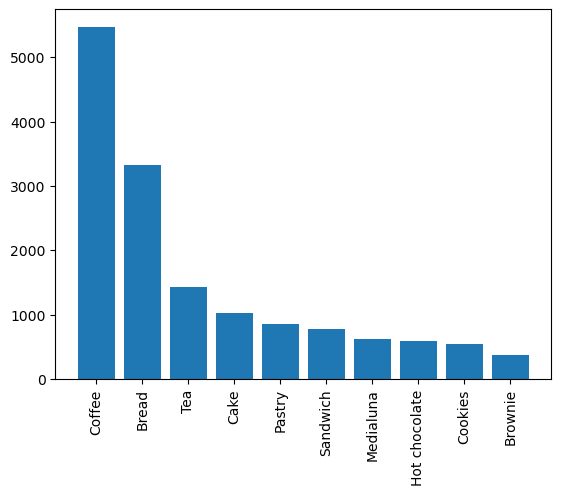

In [167]:
from collections import Counter
from matplotlib import pyplot as plt
dataset = [[item for item in transaction if item != 'NONE'] for transaction in dataset]
dataset = list(filter(None, dataset))
c = Counter()
for sublist in dataset:
    c.update(sublist)
top_ten = c.most_common(10)

plt.xticks(rotation='vertical')
plt.bar([val[0] for val in top_ten], [val[1] for val in top_ten])
plt.show()


Q4. 

a.) Using `mlxtend.preprocessing.TransactionEncoder`, transform `dataset` into an array format suitable for the `mlxtend` library. You will need to call `fit` then `transform`. 

`TransactionEncoder` learns unique items from the dataset and transforms each transaction into a one-hot encoded boolean numpy array. For example, the resulting encoded dataset will be represented by something like this, where each row is a transaction. If the first transaction contained ['Crepe', 'Jam'], this would correspond to the first row in the encoded table. 

<img src="table.png">

Print the `shape` of the resulting encoded numpy array.

b.) `TransactionEncoder` also has a function `inverse_transform` that allows you to tranform one-hot encoded transactions back to the item labels. Try it out on the first 5 transactions and display the items in the first 5 transactions.

In [168]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(dataset).transform(dataset)
print("Shape: ", te_array.shape)
first5 = te_array[:5]
print("First 5 inverse: " , te.inverse_transform(first5))

Shape:  (9465, 94)
First 5 inverse:  [['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin'], ['Bread', 'Coffee', 'Pastry']]


Q5. Convert the encoded numpy array from Q4 part a into a pandas dataframe. Use the `TransactionEncoder`'s `.columns_` attribute as the column headers. Print the head of the resulting dataframe. 

In [169]:
te_df = pd.DataFrame(te_array, columns=te.columns_)
te_df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Q6. Use the `mlxtend.frequent_patterns.apriori` to generate the frequent itemsets with minimum support of 1%. Display these itemsets along with their support values.

In [170]:
from mlxtend.frequent_patterns import apriori
apr_freq = apriori(te_df, min_support=0.01, use_colnames=True)
apr_freq

,support,itemsets
0,0.036344,(Alfajores)
1,0.016059,(Baguette)
2,0.327205,(Bread)
3,0.040042,(Brownie)
4,0.103856,(Cake)
...,...,...
56,0.023666,"(Toast, Coffee)"
57,0.014369,"(Tea, Sandwich)"
58,0.010037,"(Bread, Coffee, Cake)"
59,0.011199,"(Bread, Coffee, Pastry)"


Q7. Use `mlxtend.frequent_patterns.fpmax` to find and display all of the maximal frequent itemsets along with their support values. 

In [171]:
from mlxtend.frequent_patterns import fpmax
fpmax(te_df, min_support=0.01, use_colnames=True)

,support,itemsets
0,0.010460,(Salad)
1,0.010565,(Hearty & Seasonal)
2,0.012995,(Chicken Stew)
3,0.013207,(Jammie Dodgers)
4,0.014157,(Mineral water)
5,0.015003,(Jam)
6,0.015003,(Fudge)
7,0.015425,(Tiffin)
8,0.016059,(Baguette)
9,0.010882,"(Spanish Brunch, Coffee)"


Q8. Use `mlxtend.frequent_patterns.association_rules` to calculate rules with a confidence level of 0.25 for the frequent itemsets you generated in Q6.

In [172]:
from mlxtend.frequent_patterns import association_rules
association_rules(apr_freq, metric="confidence", min_threshold=0.25)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Alfajores),(Bread),0.036344,0.327205,0.010354,0.284884,0.870657,-0.001538,0.940818,-0.133570
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
2,(Brownie),(Bread),0.040042,0.327205,0.010777,0.269129,0.822508,-0.002326,0.920538,-0.183536
3,(Bread),(Coffee),0.327205,0.478394,0.090016,0.275105,0.575059,-0.066517,0.719561,-0.523431
4,(Cookies),(Bread),0.054411,0.327205,0.014474,0.266019,0.813004,-0.003329,0.916638,-0.195651
5,(Medialuna),(Bread),0.061807,0.327205,0.016904,0.273504,0.835879,-0.003319,0.926082,-0.173062
6,(Pastry),(Bread),0.086107,0.327205,0.029160,0.338650,1.034977,0.000985,1.017305,0.036980
7,(Brownie),(Coffee),0.040042,0.478394,0.019651,0.490765,1.025860,0.000495,1.024293,0.026259
8,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
9,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700


Q9. An important step in generating a set of association rules is to determine the optimal thresholds for support and confidence. If we set these values too low we will get a lot of rules and most of them will not be useful. 

Generate the frequent itemsets with minimum support of 0.5% and plot the number of rules generated with respect to the confidence threshold by varying its value between 0 and 1 with increments of 0.1. Notice what happens when we increase the confidence level.

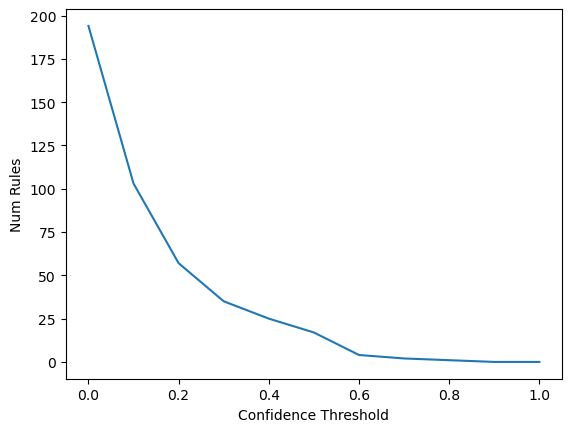

In [175]:
num_rules = []
confidence_thresh = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8 ,0.9, 1] 
apr_test = apriori(te_df, min_support=0.005, use_colnames=True)
for conf in confidence_thresh : 
    rules = association_rules(apr_test, metric="confidence", min_threshold=conf)
    num_rules.append(len(rules))
plt.plot(confidence_thresh, num_rules)
plt.xlabel("Confidence Threshold")
plt.ylabel("Num Rules")
plt.show()

Q10. What value would you choose for the minimum confidence threshold based on the plot in Q9? Explain why as a comment. 

Display the rules generated for the your chosen value. Take a look at the generated rules. Are they interesting? As a comment, explain why or why not.

In [176]:
# I would choose 0.3, that is the elbow of the graph and the rule count become minimal as confidence increases
association_rules(apr_test, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
1,(Jam),(Bread),0.015003,0.327205,0.005071,0.338028,1.033076,0.000162,1.016349,0.032505
2,(Pastry),(Bread),0.086107,0.327205,0.029160,0.338650,1.034977,0.000985,1.017305,0.036980
3,(Brownie),(Coffee),0.040042,0.478394,0.019651,0.490765,1.025860,0.000495,1.024293,0.026259
4,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
5,(Chicken Stew),(Coffee),0.012995,0.478394,0.005177,0.398374,0.832732,-0.001040,0.866994,-0.169098
6,(Coke),(Coffee),0.019440,0.478394,0.006445,0.331522,0.692989,-0.002855,0.780289,-0.311204
7,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
8,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926,0.115303
9,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403


In [ ]:
# what is interesting is how many rules have coffee as a consequent, this is because it is by far the most frequent item in the dataset 